In [ ]:
# Standard library imports
import math
import os
import re
import shutil
import sys
import unicodedata
import warnings
from itertools import product

# Third-party library imports
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

## Helper functions

In [140]:
# 🆕🆗✅❌🚫⛔️❔❓❕❗️➕✔️📂📁🗃️🗄️⏸️🚨

### Security

In [ ]:
# SANITIZATION FUNCTION
import os
import re
import warnings
import unicodedata
#%config Warnings.use_simple_formatting = True

def remove_accents(input_str):
    """Removes accents from a string, issuing a warning if changes are made."""
    original_str = input_str  # Store the original string for comparison
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    result = "".join(c for c in nfkd_form if not unicodedata.combining(c))

    if result != original_str:  # Check if any changes were made
        warnings.warn("CAUTION: Accents were removed from input.", UserWarning)

    return result

def sanitize_filename(filename):
    """Sanitizes a filename by removing accents and disallowed characters."""
    filename = remove_accents(filename)  # Remove accents first
    allowed_chars = r"^[a-zA-Z0-9_\-\.]+$"
    if not re.fullmatch(allowed_chars, filename):
        raise ValueError("Invalid filename: Contains disallowed characters.")
    return filename

def get_safe_basename(filepath):
    try:
        safe_filename = sanitize_filename(original_filename)
        if original_filename != safe_filename:  # Check for differences AFTER basename
            warnings.warn("CAUTION: Filename was changed during sanitization.", UserWarning)
    except ValueError as e:
        warnings.warn("CAUTION: Filename is unsafe. Using sanitized version.", UserWarning)
        safe_filename = re.sub(r"[^a-zA-Z0-9_\-\.]", "", original_filename)  # Sanitize (remove invalid chars)

    return safe_filename

filepath = input("Enter a file path: ")  # Example: "path/to/my-file!.txt"

safe_basename = get_safe_basename(filepath)
print(f"Original input: '{filepath}'")
print(f"Safe basename: '{safe_basename}'")

# ... use safe_basename for file operations ...

In [ ]:
# DECORATOR SANITIZATION FUNCTION:
# Safety Mesaures for verfying potential harmful user inputs

def remove_accents(input_str):
    """Replace accents from a string with equivalent letter, issuing a warning if changes are made."""
    original_str = input_str  # Store the original string for comparison
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    result = "".join(c for c in nfkd_form if not unicodedata.combining(c))

    if result != original_str:  # Check if any changes were made
        warnings.warn(f"Accents were removed from input. ('{original_str}' -> '{result}')", UserWarning)

    return result

def sanitize_filename(input_str):
    """Sanitizes a filename by removing accents and disallowed characters."""
    input_str = remove_accents(input_str)  # Remove accents first
    result = input_str

    # Checks for prohibited characters (then deletes them)
    allowed_chars = r"^[a-zA-Z0-9_\-\.]+$"
    if not re.fullmatch(allowed_chars, input_str):
        result = re.sub(r"[^a-zA-Z0-9_\-\.]", "", input_str)  # Sanitize (remove invalid chars)
        warnings.warn(f"This argument is unsafe. A sanitized version will be used instead. ('{input_str}' -> '{result}')", UserWarning)

    return result

# Decorator wrapper function
def validate_filenames():
    def decorator(func):
        def wrapper(*args, **kwargs):

            # Arguments Sanitization 
            sanitized_args = []
            for arg in args:
                if isinstance(arg, str):
                    original_arg = arg
                    sanitized_arg = sanitize_filename(arg) # Sanitize argument
                    if sanitized_arg != original_arg:
                        warnings.warn(f"Argument '{original_arg}' sanitized to '{sanitized_arg}'.", UserWarning)
                else:
                    sanitized_arg = arg
                    warnings.warn(f"Argument '{arg}' is not string. Be sure the current function can handle it.", UserWarning)
                sanitized_args.append(sanitized_arg)

            # Keyword Arguments Sanitization 
            sanitized_kwargs = {}
            for key, value in kwargs.items():
                if isinstance(value, str):
                    original_value = value
                    sanitized_value = sanitize_filename(value) # Sanitize value for keyword
                    if sanitized_value != original_value:
                        warnings.warn(f"Keyword argument '{key}'='{original_value}' sanitized to '{sanitized_value}'.", UserWarning)
                else:
                    sanitized_value = value
                    warnings.warn(f"Argument '{value}' is not string type. Be sure the current function can handle it.", UserWarning)
                sanitized_kwargs[key] = sanitized_value

            # Return sanitized arguments
            return func(*sanitized_args, **sanitized_kwargs)
        return wrapper
    return decorator


### File management

In [ ]:
@validate_filenames()
def create_dir(folder_path):
    # 1) Verifica si el directorio existe y confirma si es necesario vaciarlo
    if os.path.exists(folder_path):
        print(f"🚨 ALERTA: El directorio en el que quieres guardar ya tiene contenido, para proceder deberás eliminarlo.")
        confirmation = input(f"❓¿Estás seguro de que deseas eliminar el directorio '{folder_path}' y su contenido? (y/n): ").lower()
        if confirmation in ['y', 'yes']:
            shutil.rmtree(folder_path)  # Elimina el directorio y todo su contenido
            print("> Directorio eliminado:\n",folder_path)
        else:
            print(f"❌ Operación cancelada por el usuario. El directorio no se eliminó.\n⏸️ La ejecución se ha detenido.")
            sys.exit()
    else:
        print("🆕 El directorio no existe, se creará uno nuevo:",{folder_path})
        
    # 2) Crea el directorio especificado
    os.makedirs(folder_path, exist_ok=True)
    print("✅ El directorio ya está disponible:\n",{folder_path})

In [ ]:
@validate_filenames()
def empty_dir(folder_path):
    """
    Elimina todo el contenido (archivos y subdirectorios) de una carpeta especificada.

    Args:
        folder_path: La ruta de la carpeta que se va a limpiar.

    Raises:
        FileNotFoundError: Si la carpeta especificada no existe.
        OSError: Si ocurre un error durante la eliminación de archivos o directorios.
    """

    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"❗️La carpeta '{folder_path}' no existe.")

    try:
        confirmation = input(f"❓¿Estás seguro de que deseas eliminar el contenido de '{folder_path}'? (y/n): ").lower()
        if confirmation in ['y', 'yes']:
            for file in os.listdir(folder_path):  # Itera sobre los archivos y directorios
                file_path = os.path.join(folder_path, file)  # Crea la ruta completa

                if os.path.isfile(file_path):  # Si es un archivo
                    os.remove(file_path)  # Elimina el archivo
                    #print(f"Archivo eliminado: {file_path}")

                elif os.path.isdir(file_path):  # Si es un directorio
                    shutil.rmtree(file_path)  # Elimina el directorio y su contenido de forma recursiva
                    #print(f"Directorio eliminado: {file_path}")

            print("✔️ Contenido de la carpeta eliminado:\n", folder_path)

        else:
            print(f"❌ Operación cancelada por el usuario. El directorio no se eliminó.\n⏸️ La ejecución se ha detenido.")
            sys.exit()

    except OSError as e:
        raise OSError(f"🚫 Error al limpiar la carpeta:\n {e}")    
    except FileNotFoundError as e:
        print(f"🚨 El archivo no existe:\n {e}")
    except Exception as e:
        raise Exception(f"❗️ Error inesperado:\n {e}")

In [ ]:
@validate_filenames()
def build_filename(dset: str, type: str, dir: str='in', prefix: str = '', name: str | None = None, verbose: bool = False) -> str:
    """ 
    Construye el nombre y ruta necesaria para cargar/guardar cada archivo del dataset.

    Parámetros:
        - dset (str): Nombre del subconjunto de datos sobre el que se trabaja ('train', 'valid' o 'test').
        - prefix (str): Establece un prefijo para el archivo.
        - type (str): Tipo de archivo ('image' o 'label').
        - dir (str): Dataset de entrada o de salida ('in' o 'out').
        - name (str, optional): Nombre de archivo (sin extension). Si es None, devuelve la ruta de la carpeta.
        - verbose (bool): Ofrece información verbal al usuario.

    Retorna:
        - str: Por defecto entega la ruta de la carpeta.
        - Si se incluye un nombre de archivo, devuelve la ruta con el formato adecuado.
    """
    assert (isinstance(name, str | None)
            and isinstance(dset, str)
            and isinstance(type, str)
            and isinstance(prefix, str)
            and isinstance(dir, str)), "❕All arguments must be strings."
    
    # This help splitting the name in half
    # for inserting the prefix next to photo filename (eg: 209_205_50_JPG)
    pointer = name.find('.rf.') if name != None else "" # could be modified for differente tag name formats

    file_type = ['images', 'labels']
    file_ext = ['jpg', 'txt']
    set_path = ['train/','valid/','test/']
    
    # Example:
    #    - in: "/data/raw/3.5m.v3i.yolov8/valid/labels/
    #            209_205_50_JPG.rf.a6fdbfed5ddcebe949b5a721c39c6a1f.txt"
    #    - out: "/data/processed/3.5m.v3i.yolov8/valid/labels/
    #            tile00x00.209_205_50_JPG.rf.a6fdbfed5ddcebe949b5a721c39c6a1f.txt"
    #    - shape: /data/{dir}/{PATH}/{dset}/{type}/ <- Folder path
    #             {prefix}.{filename}.{type}        <- Full filename

    if dir == 'out':
        root = PATH.replace('raw','processed')
    elif dir == 'in':
        root = PATH
    else:
        raise ValueError("❕Invalid 'dir': must be 'in' (default) or 'out'.")

    match dset.lower():
        case 'train':
            dset = set_path[0]
        case 'valid':
            dset = set_path[1]
        case 'test':
            dset = set_path[2]
        case _:
            raise ValueError("❕Invalid 'dset': must be 'train', 'valid', or 'test'.")

    if type == 'image':
        type_folder = file_type[0]
        extension = file_ext[0]
    elif type == 'label':
        type_folder = file_type[1]
        extension = file_ext[1]
    else:
        raise ValueError("❕Invalid 'type': must be 'image' or 'label'.")
    
    if name == None or '':
        filename = ''
        print("🚨 WARNING: Prefix will be ignored unless a filename is provided.") if prefix else ''
    else:
        if not prefix:
            # If no prefix is defined, it keeps the original name
            filename = f"{name}.{extension}"
        else:
            if pointer == -1:
                # When the reference in name format is not find, it add the prefix at the end
                filename = f"{name}.{prefix}.{extension}"
            else:
                # If the format is ok, it insert the prefix in between the original JPG filename and the hash part
                name_jpg = name[:pointer]
                name_hash = name[pointer:]
                filename = f"{name_jpg}.{prefix}{name_hash}.{extension}"
                
    if verbose:
        print("✔️ Filename created succesfully")

    return f"{root}{dset}{type_folder}/{filename}"

In [113]:
PATH = testing_input_1
PATH = "../casa/"
PATH = os.path.basename(PATH)
build_filename('test','label','in','this_text_is_ok','09')

'test/labels/09.this_text_is_ok.txt'

In [144]:
def filenames_for_tiles(dset: str, type: str, dir: str='in', name: str | None = None) -> callable:
    """ 
    Crea una función anidada para generar nombres de archivo y ruta para cada mosaico.

    Parámetros:
        - dset (str): Nombre del subconjunto de datos sobre el que se trabaja ('train', 'valid' o 'test').
        - type (str): Tipo de archivo ('image' o 'label').
        - dir (str): Dataset de entrada o de salida ('in' o 'out').
        - name (str, optional): Nombre de archivo (sin extension). Si es None, devuelve la ruta de la carpeta.

    Retorna:
        - callable: Retorna la función generadora anidada.
    """
    def generate_filename(prefix: str = '') -> str:
        """
        Construye el nombre y ruta para el mosaico especificado.
        """
        return build_filename(dset=dset, type=type, dir=dir, prefix=prefix, name=name, verbose=False)

    return generate_filename  # Return the nested function

In [ ]:
@validate_filenames()
def save_labels(dest_labels_file: str, export: pd.DataFrame, verbose: bool = True) -> bool:
    """
    Saves a DataFrame to a file, with each row as a space-separated string.

    Args:
        dest_labels_file: Path to the output file.
        export: DataFrame to save.

    Returns:
        True if the file was saved successfully, False otherwise.
    """
    try:
        lines = label_to_str(export)
        with open(dest_labels_file, 'w') as file:
            file.writelines(line + "\n" for line in lines)
        if verbose:
            print("El archivo de etiquetas se ha creado correctamente. Se han guardado todos los datos.")
        return True
    
    except OSError as e:
        raise OSError(f"🚫 Error al copiar la carpeta:\n {e}")
    except FileNotFoundError as e:
        print(f"🚨 El archivo no existe:\n {e}")
    except Exception as e:
        raise Exception(f"❗️ Error inesperado:\n {e}")


### Formatting

In [146]:
def label_to_str(export: pd.DataFrame) -> list[str]:
    
    """
    Converts each row of a dataframe into string format

    Parameters:
    - Dataframe with labels (np.dataframe)

    Returns:
    - List with labels in text (list[str])
    """
    
    lines = []
    for _, row in export.iterrows():
        row_list = list(row)
        row_list[0] = int(row_list[0])
        line = ' '.join(map(str, row_list))
        lines.append(line)
        
    # Verificar que la cantidad de lineas coincide con la cantidad de labels
    if not len(lines) == len(export):
        raise ValueError("🚨 CUIDADO: el número de etiquetas en el archivo de salida y el dataframe no coinciden.")

    return lines

In [147]:
def get_index(row:int , column:int ) -> int:
    """
    Calcula el índice lineal en una estructura de datos de los mosaicos definidos en el setup inicial.

    Parámetros:
    - row: Número de fila (entero).
    - column: Número de columna (entero).

    Salida:
    - Índice lineal calculado. 
    """
    if not isinstance(COLUMNS, int):
        raise TypeError(f"❕La constante columna no está definida adecuadamente. (value:{COLUMNS})")
    if not isinstance(row, int) or not isinstance(column, int):
        raise TypeError("❕Debe introducir valores enteros para fila y columna.")
    if row < 0 or column < 0:
        raise ValueError("❕Fila y columna deben ser valores no negativos.")

    return column + (row * COLUMNS)

In [148]:
def to_origin(labels: pd.DataFrame, coord: list):
    """
    Lleva las coordenadas a la ordenada para que la gráfica sea comparativa
    """
    labels = labels.copy()
    labels[['x0', 'y0', 'x1', 'y1']] = labels[['x0', 'y0', 'x1', 'y1']].astype(int)
    labels[['x0', 'y0', 'x1', 'y1']] -= coord * 2
    return labels

In [149]:
def label_transform(df_labels: pd.DataFrame, mode: str, im_height: int = 3648, im_width: int = 5472, round: bool = True) -> pd.DataFrame:
    """
    Transforms bounding box coordinates based on the specified mode.

    Args:
        df_labels: DataFrame containing bounding box coordinates (x, y, width, height).
        mode: Transformation mode ('absolute' or 'relative').
        im_height: Image height in pixels (default: 3648).
        im_width: Image width in pixels (default: 5472).

    Returns:
        Transformed DataFrame with bounding box coordinates.

    Raises:
        AssertionError: If im_width or im_height is not an integer.
        ValueError: If mode is not 'absolute' or 'relative'.
    """

    assert isinstance(im_width, int), "Dimensions should be int numbers."
    assert isinstance(im_height, int), "Dimensions should be int numbers."
    assert isinstance(mode, str), "Mode should be a string"    
    assert isinstance(df_labels, pd.DataFrame), "df_labels must be a pandas DataFrame"

    if im_height == 0 or im_height == 0:
        raise ValueError("❕Debe introducir las dimensiones de la imagen (no pueden ser 0).")
    if mode == 'absolute':
        df_labels_abs = df_labels * [1, im_width, im_height, im_width, im_height]
        if round:
            df_labels_abs = df_labels_abs.round(0).astype(int)
        df_labels_abs['class_id'] = df_labels_abs['class_id'].astype(int)
        return df_labels_abs
    elif mode == 'relative':
        df_labels_rel = df_labels / [1, im_width, im_height, im_width, im_height]
        df_labels_rel['class_id'] = df_labels_rel['class_id'].astype(int)
        return df_labels_rel
    else:
        raise ValueError("❕Debe indicar el modo de transformación deseado ('absolute' o 'relative')")
    

In [150]:
def lbl_to_bb(df_input: pd.DataFrame) -> pd.DataFrame:

    """
    Transforma un DataFrame de 'Etiquetas' a 'Bounding Boxes'.
    
    Args:
        df_input: Dataframe de coordenadas de Labels (x, y, width, height).
        
    Returns:
        df_output: Dataframe de coordenadas de Bounding Boxes (x0, y0, x1, y1).
    """
    
    # Extraer los valores como arrays NumPy (evita el overhead de Pandas)
    class_id = df_input['class_id'].values
    x_center, y_center = df_input[['x_center', 'y_center']].to_numpy().T
    width, height = df_input[['width', 'height']].to_numpy().T

    # Calcular coordenadas de bounding box de manera vectorizada
    x0 = np.floor(x_center - width / 2)
    x1 = np.floor(x_center + width / 2)
    y0 = np.floor(y_center - height / 2)
    y1 = np.floor(y_center + height / 2)

    # Crear el DataFrame con los resultados optimizados
    return pd.DataFrame({'class_id': class_id, 'x0': x0, 'x1': x1, 'y0': y0, 'y1': y1}).astype(int)


def bb_to_lbl(df_input: pd.DataFrame) -> pd.DataFrame:
    
    """
    Transforma un DataFrame de 'Bounding Boxes' a 'Etiquetas'.
    
    Args:
        df_input: Dataframe de coordenadas de Bounding Boxes (x0, y0, x1, y1).
        
    Returns:
        df_output:  Dataframe de coordenadas de Labels (x, y, width, height).

    """

    # Extraer los valores de las coordenadas de los Bounding Boxes como arrays NumPy
    class_id = df_input['class_id'].values
    x0, x1 = df_input['x0'].values, df_input['x1'].values
    y0, y1 = df_input['y0'].values, df_input['y1'].values

    # Calcular las coordenadas del centro usando NumPy
    x_center = (x0 + x1) / 2
    y_center = (y0 + y1) / 2

    # Calcular el ancho (width) y la altura (height) usando NumPy
    width = x1 - x0
    height = y1 - y0

    # Crear el DataFrame con los resultados optimizados usando NumPy
    return pd.DataFrame({
        'class_id': class_id, 
        'x_center': x_center, 
        'y_center': y_center, 
        'width': width, 
        'height': height
    }).astype(int)

### Visualization tools

In [151]:
def draw_points(image: np.ndarray, df_labels: pd.DataFrame):
    """
    Dibuja en la imagen los centroides de cada Bounding Box.

    Parámetros:
    - image: np.ndarray -> Imagen sobre la que se dibujarán los bounding boxes.
    - df_labels: pd.DataFrame -> DataFrame con columnas ['class_id','x_center', 'y_center', 'width', 'height'].
    """
    
    im_points = image.copy()
    
    # Dibujar puntos
    for _, row in df_labels.iterrows():
        x = row['x_center']
        y = row['y_center']
        point = [x, y]
        
        # Dibujar los círculos
        cv.circle(im_points, center=point, radius=7, color=(255, 0, 0), thickness=-1)
    
    # Mostrar imagen con puntos
    fig = plt.figure(figsize=(12, 8))
    plt.imshow(im_points)
    plt.show()

In [152]:
def draw_bb(image: np.ndarray, labels: pd.DataFrame, coord: tuple | list | str=(0, 0, 240, 240)):
    """
    Dibuja bounding boxes en una imagen basándose en las etiquetas proporcionadas.

    Parámetros:
    - image: np.ndarray -> Imagen sobre la que se dibujarán los bounding boxes.
    - labels: pd.DataFrame -> DataFrame con columnas ['x0', 'y0', 'x1', 'y1', 'class_id'].
    - coord: tuple | list | str -> Coordenadas del tile en formato (x0, y0, x1, y1).    
    """
    im_points = image.copy()

    # Convertir `coord` a una lista de enteros si es necesario
    if isinstance(coord, str):
        coord = [int(x) for x in coord.split()]
    elif isinstance(coord, tuple):
        coord = list(coord)
    elif not isinstance(coord, list):
        raise ValueError("❗️La variable de coordenadas  debe ser una lista, tupla o string con coordenadas.")

    # Verificar que `coord` tenga 4 valores
    if len(coord) != 4:
        raise ValueError("❗️La variable de coordenadas debe contener exactamente 4 valores (x0, y0, x1, y1).")

    # Lleva las coordenadas al origen para que la gráfica sea comparativa
    #labels['x0', 'y0', 'x1', 'y1'] = to_origin(labels[['x0', 'y0', 'x1', 'y1']], coord[:2])
    labels[['x0', 'y0', 'x1', 'y1']] = labels[['x0', 'y0', 'x1', 'y1']].astype(int)
    labels[['x0', 'y0', 'x1', 'y1']] -= coord[:2] * 2
    
    # Generar colores únicos para cada class_id
    unique_classes = labels['class_id'].unique()  # Obtener clases únicas
    color_map = {cls: tuple(np.random.randint(0, 255, 3).tolist()) for cls in unique_classes}
    
    # Dibujar puntos
    for _, label in labels.iterrows():
        label.class_id
        
        color = color_map[label.class_id]
        Pi = (label.x0, label.y0)
        Po = (label.x1, label.y1)
        
        # Dibujar los círculos
        cv.rectangle(im_points, Pi, Po, color=color, thickness=1)
    
    # Mostrar imagen con puntos
    fig = plt.figure(figsize=(12, 8))
    plt.imshow(im_points)
    plt.show()

In [153]:
def test_label(tile , box):
    # Input format: x0 y0 x1 y1
    tile_coords = tile.split()
    box_coords = box.split()

    # Transforma las coordenadas ingresadas por el usuario de str a list[int]
    tile_coords = [int(x) for x in tile_coords]
    box_coords = [int(x) for x in box_coords]
    ref_coords = tile_coords.copy()

    # Lleva las coordenadas al origen para que la gráfica sea comparativa
    tile_coords = [box - tile for box, tile in zip(tile_coords, ref_coords[:2] * 2)]
    box_coords = [box - tile for box, tile in zip(box_coords, ref_coords[:2] * 2)]
    
    # Crear la figura y los ejes
    fig, ax = plt.subplots(figsize=(3, 3))
    
    #                +------------------+
    #                |                  |
    #              height               |
    #                |                  |
    #               (xy)---- width -----+
    
    # anchor: x0, y1
    # width: x1 - x0
    # height: y1- y0
    
    # Dibujar tile (rojo)
    tile_rect = plt.Rectangle((tile_coords[0], tile_coords[1]), # anchor (xy)
                              tile_coords[2] - tile_coords[0], # width
                              tile_coords[3] - tile_coords[1], # height
                              edgecolor='red', facecolor='none', linewidth=2)                              
    # Dibujar box (azul)
    box_rect = plt.Rectangle((box_coords[0], box_coords[1]), 
                             box_coords[2] - box_coords[0], 
                             box_coords[3] - box_coords[1], 
                             edgecolor='blue', facecolor='none', linewidth=2)
    
    # Agregar los rectángulos a la gráfica
    ax.add_patch(tile_rect)
    ax.add_patch(box_rect)
    
    # Configurar límites y aspecto
    ax.set_xlim(-10, max(tile_coords[2], box_coords[2]) + 10)
    ax.set_ylim(-10, max(tile_coords[3], box_coords[3]) + 10)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    plt.axis('off')
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
    plt.show()

### Utils

In [154]:
import time

# Decorador para medir el tiempo de ejecución
def duration(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()  # Momento de inicio
        result = func(*args, **kwargs)  # Ejecuta la función
        end_time = time.time()  # Momento de fin
        execution_time = end_time - start_time  # Calcula el tiempo de ejecución
        print(f"\nTiempo de ejecución de {func.__name__}: {execution_time:.6f} segundos")
        return result
    return wrapper

## Settings
Set every parameter for the dataset you need to process

In [122]:
# Batch splitting (full dataset folder)
subset_opt = ['train','valid']
type_opt = ['image', 'label']
order = 0
files = []

In [123]:
# CONFIGURAR DATASET A PROCESAR
PATH_LOCATION = '../../'
DATASET_NAME = '3.5m.v3i.yolov8'
SUBSET = subset_opt[0] # 0: train / 1: valid

# Procesamiento del dataset

## Ejecución inicial
Debe ejecutarse sólo una vez al iniciar el proceso

In [124]:
PATH = f'{PATH_LOCATION}data/raw/{DATASET_NAME}/'
print("Directorio:", PATH)
input_dir = build_filename(SUBSET,'image')

Directorio: ../../data/raw/3.5m.v3i.yolov8/


### Safety check for user inputs

In [ ]:
"""
# Verifica parámetros constantes seteadas por el usuario
for file in [PATH_LOCATION, DATASET_NAME, SUBSET, PATH]:
    print(file)
    result = validate_filenames(file)
    print(result)

# Verifica otras variables dependientes de input de usuario
# Evita posibles rutas que puedan representar un punto de ataque
"""

### Copiado del dataset raíz

In [158]:
output_dir = build_filename(SUBSET,'image', 'out')
output_dir = output_dir[:output_dir.find(SUBSET)]
print("Se realizará el procesamiento del dataset en los siguientes directorios")
print(PATH,'-->',output_dir)

Se realizará el procesamiento del dataset en los siguientes directorios
../../data/raw/3.5m.v3i.yolov8/ --> ../../data/processed/3.5m.v3i.yolov8/


In [159]:
# CRECIÓN DEL DIRECTORIO DE DESTINO (data/processed)
# Se copia la estructura base y archivos generales del dataset de origen

if not os.path.exists(PATH):
    raise FileNotFoundError(f"⛔️ La carpeta de origen '{PATH}' no existe.")

try:
    # Verifica si la carpeta de destino existe, si no, la crea
    create_dir(output_dir)

    # Copia la carpeta de forma recursiva, incluyendo subdirectorios y archivos
    shutil.copytree(PATH, output_dir, dirs_exist_ok=True)

    print(f"✅ El dataset de origen ha sido copiado con éxito:\n'{PATH}' --> '{output_dir}'")

except OSError as e:
    raise OSError(f"🚫 Error inesperado al copiar la carpeta:\n {e}")
except Exception as e:
    raise Exception(f"❗️ Error inesperado:\n {e}")


🚨 ALERTA: El directorio en el que quieres guardar ya tiene contenido, para proceder deberás eliminarlo.


KeyboardInterrupt: Interrupted by user

### Eliminación del contenido original

In [137]:
# Crea el directorio de almacenamiento
print("Removing existing dataset files for images and labels folders…")
for s in subset_opt:
    for t in type_opt:
        print()
        print(s.upper(), t.upper(), sep="/", end=":\n")
        output_dir = build_filename(s,t,'out')
        try:
            empty_dir(output_dir)
        except FileNotFoundError as e:
            print(f"🚨 El archivo no existe: {e}")
        except OSError as e:
            print(f"🚫 Error al vaciar la carpeta:\n {e}")
print()
print("✅ El proceso se ha completado de forma exitosa.")

Removing existing dataset files for images and labels folders…

TRAIN/IMAGE:
✔️ Contenido de la carpeta eliminado:
 ../../data/processed/3.5m.v3i.yolov8/train/images/

TRAIN/LABEL:
✔️ Contenido de la carpeta eliminado:
 ../../data/processed/3.5m.v3i.yolov8/train/labels/

VALID/IMAGE:
✔️ Contenido de la carpeta eliminado:
 ../../data/processed/3.5m.v3i.yolov8/valid/images/

VALID/LABEL:
❌ Operación cancelada por el usuario. El directorio no se eliminó.
⏸️ La ejecución se ha detenido.


SystemExit: 

/Users/alejandrolloveras/Library/Python/3.13/lib/python/site-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Procesamiento de cada archivo 
Debe ejecutarse de forma iterativa hasta finalizar el proceso

In [93]:
DATASET_NAME = PATH[PATH.find('raw')+4:-1]
input_dir = build_filename(SUBSET,'image')

try:
    files = os.listdir(input_dir)
    files = [file for file in files if file != ".DS_Store"]
    files = [file[:-4] for file in files]
    print("Dataset: ", DATASET_NAME)
    print(f"Listing files for '{SUBSET}' set\n")
    print("Indexes: 0 -",len(files)-1)
except FileNotFoundError:
    print(f"Error: La carpeta '{input_dir}' no fue encontrada.")

files

Dataset:  3.5m.v3i.yolov8
Listing files for 'train' set

Indexes: 0 - 3


['503_222_19_JPG.rf.93a87f7c65e1c44cd6ee2602e434391b',
 '209_101_24_JPG.rf.efc9c66c1f8c7766e5ddd379fe7bf3c7',
 '209_310_37_JPG.rf.fc1bab0d312b2f3ded60d51f809b6a2d',
 '209_413_15_JPG.rf.ce86a0b218e87b94667d7dffed792f76']

In [94]:
# SELECCIONAR ARCHIVO A PROCESAR
PROCESSING_FILE = files[order]
print (f'Índice {order}:\n', PROCESSING_FILE)

Índice 1:
 209_101_24_JPG.rf.efc9c66c1f8c7766e5ddd379fe7bf3c7


In [95]:
order += 1
if order == len(files):
    print("🚨ALERTA: se procesará el último archivo")

### Visualiza imagen seleccionada

In [96]:
image_file = build_filename(SUBSET,'image',name=PROCESSING_FILE)

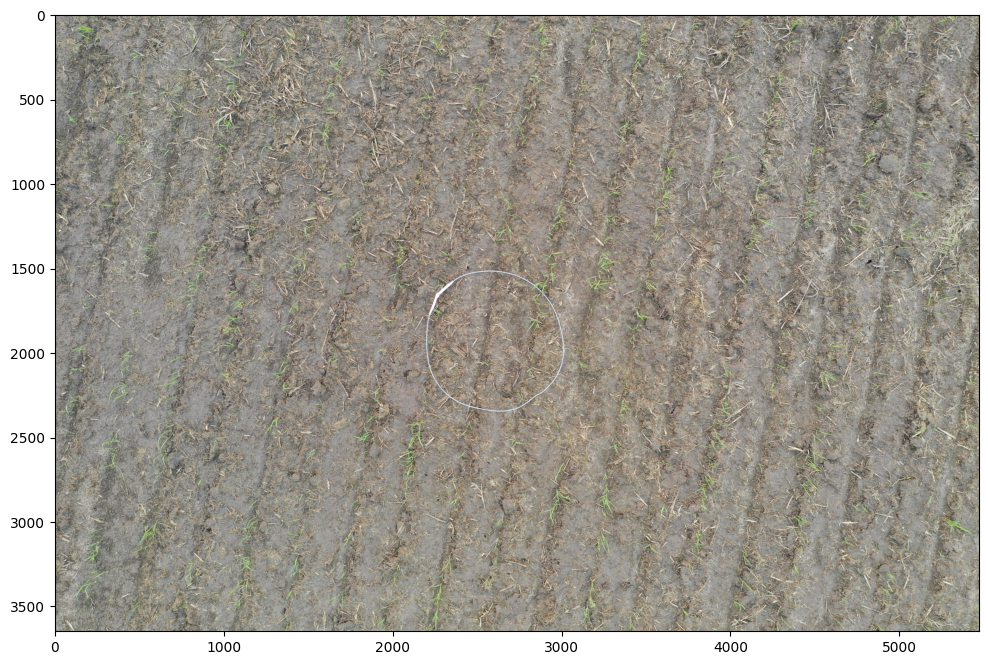

In [ ]:
image = cv.imread(image_file)

im = cv.cvtColor(image, cv.COLOR_BGR2RGB)
fig = plt.figure(figsize=(12,8))
plt.imshow(im)
plt.show()

In [98]:
H, W, _ = im.shape
im.shape
#(height, width, channels) 

(3648, 5472, 3)

# División en Tiles

**Objetivo:** Dividir la imagen en mosaicos de 240x240px

In [99]:
S = 240 # Tile size 

In [100]:
ROWS = math.ceil(H/S) # Rows
COLUMNS = math.ceil(W/S) # Columns
ROWS, COLUMNS

(16, 23)

In [101]:
print("Se dividirá la imagen en {:,} tiles".format(ROWS * COLUMNS))

Se dividirá la imagen en 368 tiles


## Agrega un borde negro para ajustar las dimensiones

In [102]:
# Dimensiones del archivo original en px
im.shape

(3648, 5472, 3)

In [103]:
center = True

if center:
    # Centra la imagen y agrega alrededor un borde negro para completar los pixeles faltantes
    im_fill = cv.copyMakeBorder(im, math.floor((S * ROWS - H)/2), math.ceil((S * ROWS - H)/2),
                                math.floor((S * COLUMNS - W)/2),  math.ceil((S * COLUMNS - W)/2),
                                cv.BORDER_CONSTANT, (0,0,0)
                               )
    # Calcular offset por redimensión de la imagen
    y_offset = math.floor((S * ROWS - H)/2)
    x_offset = math.floor((S * COLUMNS - W)/2)
    
else:
    # Agrega al final de la imagen un borde negro para completar los pixeles faltantes
    im_fill = cv.copyMakeBorder(im, 0, (S * ROWS - H), 0, (S * COLUMNS - W), cv.BORDER_CONSTANT, (0,0,0))
    
    # Informa que no existe offset en la imagen
    x_offset = 0
    y_offset = 0

In [104]:
x_offset, y_offset

(24, 96)

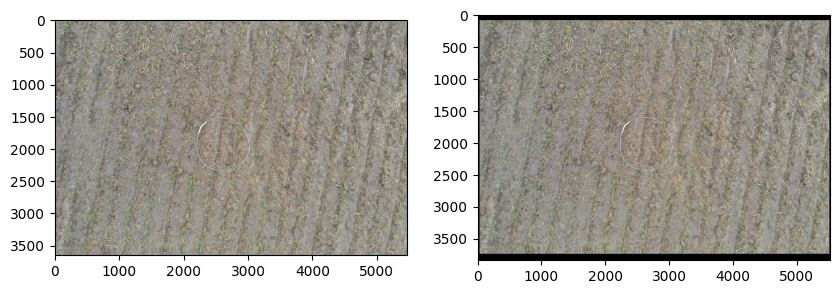

In [105]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(im)
plt.subplot(122)
plt.imshow(im_fill)
plt.show()

In [106]:
# Se verifica que la división en tiles da un entero
a, b, _ = im_fill.shape
a/S, b/S

(16.0, 23.0)

In [107]:
# Dimensiones del archivo en px (con borde negro)
im_fill.shape

(3840, 5520, 3)

## Realiza la división en mosaicos

In [108]:
tiles = [[0] * COLUMNS for _ in range(ROWS)]
tiles_dim = [[0] * COLUMNS for _ in range(ROWS)]
x0, x1, y0, y1 = 0, 0, 0, 0
count = 0

for row in range(ROWS):  # Filas primero
    for column in range(COLUMNS):  # Luego columnas
        x0 = S * column  # Basado en la columna
        y0 = S * row  # Basado en la fila
        x1 = S * (column + 1)
        y1 = S * (row + 1)
        
        # Ahora ambos tienen el mismo orden de indices
        tiles[row][column] = im_fill[y0:y1, x0:x1]  # 🔹 Corregido: usar y primero porque imágenes usan [fila, columna]
        tiles_dim[row][column] = (x0, y0, x1, y1)  # 🔹 Corrección menor: paréntesis para representar la tupla
        
        #print(row, column, ":", tiles_dim[row][column]) if column < 1 else ""
        count += 1


In [109]:
#Se verifica que las dimensiones de la lista coinciden con las de los tiles deseados
print("     ","rows", "cols")
print("tiles:", len(tiles),",", len(tiles[0]))
print("dims: ", len(tiles_dim),",", len(tiles_dim[0]))

      rows cols
tiles: 16 , 23
dims:  16 , 23


In [110]:
tiles_dim[1][0] # crece horizonalmente

(0, 240, 240, 480)

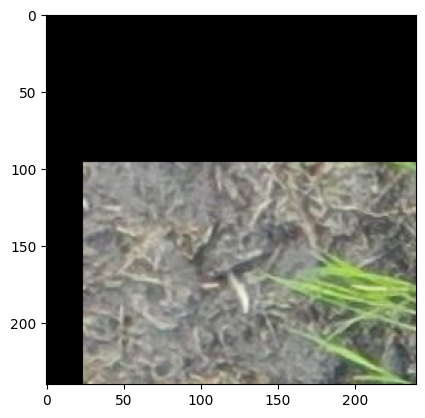

In [111]:
#rows, columns (y, x)
plt.imshow(tiles[0][0]) # crece verticalmente

# División de Bounding Boxes

**Objetivo:** Distribuir los BB para que coincidan con cada mosaico de 240x240px

__*ATENCIÓN*__ no deben perderse BB que aparecen entre 2 tiles.

### Offset setup

In [112]:
# Verifica el offset de por redimensión de imagen (borde negro)
if im_fill.shape[:2] == (H + y_offset * 2, W + x_offset * 2):
    print("Se ha verificado el offset de la imagen.") 
else:
    print("CUIDADO: Verificar offset de la imagen.")
x_offset, y_offset

Se ha verificado el offset de la imagen.


(24, 96)

### Import & dataframe convertion 

In [113]:
labels_file = build_filename(dset=SUBSET, type='label', name=PROCESSING_FILE)

In [114]:
with open(labels_file, 'r') as file:
    lines = file.readlines()
    lines = [line.strip() for line in lines]
    labels = [line.split() for line in lines]

In [115]:
# Convierte de string a int/float
labels = [[int(value) if i == 0 else float(value) 
          for i, value in enumerate(label)] for label in labels]

class_id | x_center | y_center | width | height (normalized values)

In [116]:
df_labels = pd.DataFrame(labels, columns=['class_id', 'x_center', 'y_center', 'width', 'height'])

### Absolute values

In [117]:
W, H

(5472, 3648)

In [118]:
df_labels.head(3)

class_id  x_center  y_center     width    height
0         0  0.033922  0.035776  0.017880  0.013111
1         0  0.035015  0.038871  0.006436  0.001486
2         0  0.054898  0.066532  0.012487  0.002664

In [119]:
# Se transforma el formato de relativo a absoluto
df_labels_abs = label_transform(df_labels, 'absolute')
df_labels_abs.head(3)

class_id  x_center  y_center  width  height
0         0       186       131     98      48
1         0       192       142     35       5
2         0       300       243     68      10

In [120]:
# Para verificación
index = 1
print("Verificación de fila", index)
print("{:.3f} | {:.3f} | {:.3f} | {:.3f}".format(
    df_labels.iloc[index]['x_center'] * W,
      df_labels.iloc[index]['y_center'] * H,
      df_labels.iloc[index]['width'] * W,
      df_labels.iloc[index]['height'] * H))

print(">>>  {:.0f} / {:.0f} / {:.0f} / {:.0f}".format(
    df_labels_abs.iloc[index]['x_center'],
      df_labels_abs.iloc[index]['y_center'],
      df_labels_abs.iloc[index]['width'],
      df_labels_abs.iloc[index]['height']))

Verificación de fila 1
191.600 | 141.800 | 35.220 | 5.420
>>>  192 / 142 / 35 / 5


### Offset labels

In [121]:
x_offset, y_offset

(24, 96)

In [122]:
df_labels_off = df_labels_abs + [0, x_offset, y_offset, 0, 0]
df_labels_off.head(3)

class_id  x_center  y_center  width  height
0         0       210       227     98      48
1         0       216       238     35       5
2         0       324       339     68      10

### Bounding Boxes calculation

In [123]:
df_labels_off.tail()

class_id  x_center  y_center  width  height
1010         0      3518       274     37      10
1011         0      3493       328     10      35
1012         0      3483       342     17      48
1013         0      4695       100     34       8
1014         0       489       568     24      26

In [124]:
df_BBoxes = lbl_to_bb(df_labels_off)
df_BBoxes.tail()

class_id    x0    x1   y0   y1
1010         0  3499  3536  269  279
1011         0  3488  3498  310  345
1012         0  3474  3491  318  366
1013         0  4678  4712   96  104
1014         0   477   501  555  581

### Splitting labels

1. Se utilizará este formato para almacenar cada etiqueta dentro de un mosaico
2. Se utilizará el método append para incorporar iterativamente cada etiqueta

In [125]:
# Definición de la estructura de la variable y las anotaciones de tipo
bb_tiles: list[dict[str, list | list[int] | tuple[int, int, int, int]]] = [
    {
        'dims': (0, 0, 240, 240),  # Arreglo de coordenadas del mosaico (x0,y0,x1,y1)
        'labels': [],  # Recorte de todos los labels dentro del tile
        'tile': []  # Mosaico recortado de la imagen
    }
]

In [162]:
print(f"Iniciando proceso de recorte de etiquetas…\n")
verbose = False
bb_tiles = []
count = 0
total_labels = 0
df_BBoxes_hist = []


with tqdm(total = ROWS*COLUMNS, desc="Processing Tiles") as pbar: 
    for row in range(ROWS):
        for column in range(COLUMNS):
            # Establece variables iniciales
            add_labels = []
            tile = tiles[row][column]
            tile_dim = tiles_dim[row][column]
    
            # Cálculo de coordenadas de referencia
            x0, y0, x1, y1 = tile_dim # Pi, Po
            Pi = (x0, y0)
            Po = (x1, y1)
    
            print('NUEVO MOSAICO:', "\n", x0, y0, x1, y1, "\n") if verbose else ""

            for index, label in df_BBoxes.iterrows():
                # Para cada etiqueta, verifica si se encuentra dentro del mosaico
                # Devuelve True si el punto se encuentra dentro del mosaico
                #     x0  x0+1   x1-2   x1-1 
                #     |<-------------->      Pi
                #         <-------------->|  Po
                val_x0 = True if x1-1 > label.x0 >= x0 else False
                val_y0 = True if y1-1 > label.y0 >= y0 else False
                val_x1 = True if x0 < label.x1 < x1 else False
                val_y1 = True if y0 < label.y1 < y1 else False
                
                # Verifica si el punto de inicio/final se encuentra dentro del mosaico
                val_Pi = True if (val_x0 and val_y0) else False
                val_Po = True if (val_x1 and val_y1) else False
                
                if val_Pi and val_Po:
                    #Incluye la etiqueta sin procesarla
                    if True:
                        print(count, index,":", "Se incluye la etiqueta sin procesarla") if verbose else ""
                        print('tile:', x0, y0, x1, y1) if verbose else ""
                        print('label:', label.x0,label.y0,label.x1,label.y1, "\n") if verbose else ""
                    add_labels.append(label)
                    
                elif val_Pi or val_Po:
                    # Procesa la etiqueta para incluir solo los px que pertenecen al tile
                    new_label = label.copy()
                    
                    if val_Pi:
                        print("Caso 1: inicio dentro") if verbose else ""
                        # Reemplaza final de etiqueta por borde del tile
                        if not val_x1:
                            new_label.x1 = x1
                        if not val_y1:
                            new_label.y1 = y1
                            
                    if val_Po:
                        print("Caso 2: final dentro") if verbose else ""
                        # Reemplaza inicio de etiqueta por borde del tile
                        if not val_x0:
                            new_label.x0 = x0
                        if not val_y0:
                            new_label.y0 = y0
                            
                    add_labels.append(new_label)
                    print(count, index,":", "Se ha recortado la etiqueta") if verbose else ""
                    print('original:', label.x0,label.y0,label.x1,label.y1) if verbose else ""
                    print('new:', new_label.x0,new_label.y0,new_label.x1,new_label.y1, "\n") if verbose else ""
                    
                else:
                    print(count, index,":", "La etiqueta no pertenece al mosaico") if verbose else ""
                    print('tile:', x0, y0, x1, y1) if verbose else ""
                    print('label:', label.x0,label.y0,label.x1,label.y1, "\n") if verbose else ""
            
            # Almacena las etiquetas válidas para ese mosaico
            add_labels = pd.DataFrame(add_labels, columns=['class_id', 'x0', 'y0', 'x1', 'y1'])
            new_tile = {
                'dims': tile_dim,
                'labels': add_labels,
                'tile': tile
            }
            bb_tiles.append(new_tile)
            
            #print(f"    #{count} Se han agregado {len(add_labels)} etiquetas\n")
            print() if verbose else ""
            total_labels += len(add_labels)
            count += 1
            df_BBoxes_hist.append(df_BBoxes)

            pbar.update(1)  # Update the progress bar after each tile is processed

print(f"\nPROCESO FINALIZADO:\n✅ Se han agregado un total de {total_labels} etiquetas ({total_labels/index*100:.2f}%)")

Iniciando proceso de recorte de etiquetas…



Processing Tiles: 100%|██████████| 368/368 [00:19<00:00, 19.32it/s]

PROCESO FINALIZADO:
✅ Se han agregado un total de 1289 etiquetas (127.12%)


# ❌ Verificación del proceso

In [179]:
# VALIDACIÓN DEL OUTPUT

# Verificamos que en todas las iteraciones se conserva el total de etiquetas dentro del dataframe
comp = sum(len(box) for box in df_BBoxes_hist)
check = comp / len(df_BBoxes_hist)
assert check == len(df_BBoxes), "¡Error: no se han recorrido todos los labels!"

# Verificamos que no se hayan perdido etiquetas en el proceso
assert total_labels >= len(df_labels), "¡Error: se han perdido etiquetas!"

# Verificamos que en ningún punto se hayan invertido las coordenadas por error
for index in range(len(bb_tiles)):
    assert all(label.x0 < label.x1 for _, label in bb_tiles[index]['labels'].iterrows()), "¡Error: x0 > x1!"
    assert all(label.y0 < label.y1 for _, label in bb_tiles[index]['labels'].iterrows()), "¡Error: y0 > y1!"
# NOTA: Esto lanzará un error si x0 > x1 o y0 > y1

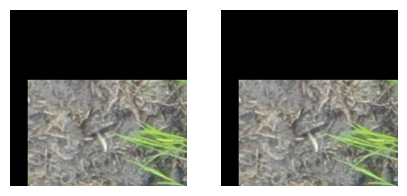

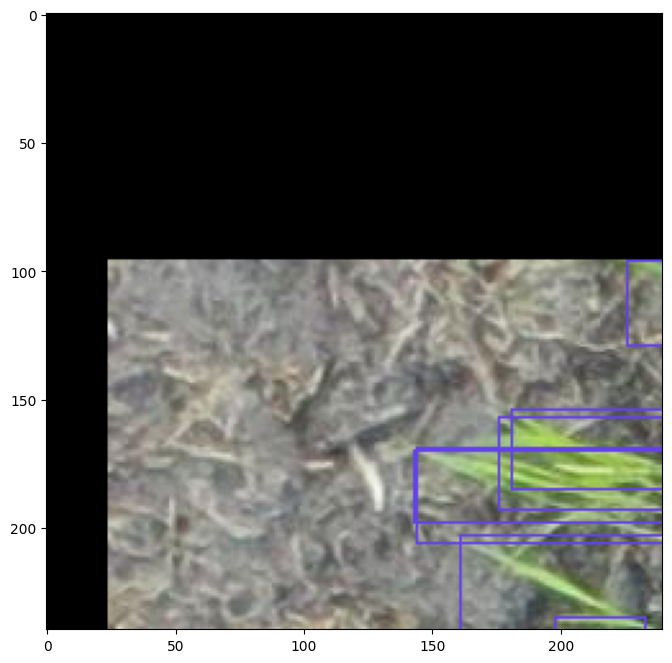


 indice 0 : (0, 0) 



class_id   x0   y0   x1   y1
0           0  161  203  240  240
1           0  198  235  233  240
3           0  144  169  240  206
4           0  143  170  240  198
5           0  176  157  240  193
6           0  181  154  240  185
987         0  226   96  240  129

In [ ]:
# Para recorrer cada valor de la matriz
row = 0 # tope 15
column = 0 # tope 22
# rows/columns: (16, 23)
index = get_index(row,column)

# 2) Visualización del mosaico:
# Se verifica que la imagen correspondiente sea la correcta
fig, axes = plt.subplots(1, 2, figsize=(5, 3))
axes[0].imshow(tiles[row][column])
axes[1].imshow(bb_tiles[index]['tile'])
axes[0].axis("off")
axes[1].axis("off")

# 1) Visualización de las etiquetas procesadas:
# Se verifica que cada etiqueta corresponda con un objeto de la imagen

# Se deben enviar copias del array y dataframe por ser objetos mutables
draw_bb(np.copy(bb_tiles[index]['tile']),
        bb_tiles[index]['labels'].copy(),
        bb_tiles[index]['dims'])


# 3) Visualización de valores:
# Se verifica que cada coordenada efectivamente esté dentro del mosaico.
print("\n","indice",index,":",bb_tiles[index]['dims'][:2],"\n")
bb_tiles[index]['labels']


# Exportación del Dataset

## Almacenamiento de imágenes

In [132]:
# Creates mested function for generating every tile filename iteratively
generate_tile_filename = filenames_for_tiles(dset=SUBSET, 
                                             type='image',
                                             dir='out', 
                                             name=PROCESSING_FILE)

In [ ]:
# Guarda las imágenes con manejo de errores
try:
    for row in range(ROWS):
        for column in range(COLUMNS):
            # Creation of filename for current tile
            #name = os.path.join(output_dir, f"tile{row:02d}x{column:02d}.JPG")
            tile_prefix = f"tile{row:02d}x{column:02d}"
            name = generate_tile_filename(tile_prefix)

            # Preparation of data to store
            index = get_index(row,column)
            data = bb_tiles[index]['tile']

            # Check if the tile data is valid (e.g., not None)
            if data is None:
                print(f"⚠️ Tile data is None for {name}, skipping.")
                continue  # Skip to the next tile

            # Convert from RGB to BGR if necessary
            if data.shape[2] == 3: # Check if it has 3 channels (color image)
                file_data = cv.cvtColor(data, cv.COLOR_RGB2BGR)
            else:
                file_data = data # If it's grayscale, no conversion needed

            success = cv.imwrite(name,file_data)
            
            if not success:
                file_name = name[(name.find('images'))+7:]
                print(f"🚫 Error al guardar:\n {file_name}")
                
except Exception as e:
    print(f"❌ Error inesperado: {e}")
else:
    print("✅ Todas las imágenes se guardaron correctamente.")

✅ Todas las imágenes se guardaron correctamente.


## Almacenamiento de etiquetas

### Adapta el formato de los datos

In [134]:
# Se ejecuta de forma iterativa dentro del siguiente script
label_transform(bb_tiles[0]['labels'],'relative')

class_id        x0        y0       x1        y1
0           0  0.029423  0.055647  0.04386  0.065789
1           0  0.036184  0.064419  0.04258  0.065789
3           0  0.026316  0.046327  0.04386  0.056469
4           0  0.026133  0.046601  0.04386  0.054276
5           0  0.032164  0.043037  0.04386  0.052906
6           0  0.033077  0.042215  0.04386  0.050713
987         0  0.041301  0.026316  0.04386  0.035362

### Almacena los datos

**"a":**  The texts will be inserted at the current file stream position, default at the end of the file.

**"w":** The file will be emptied before the texts will be inserted at the current file stream position, default 0.

**Incluir transformación de etiquetas _(abs -> rel)_**

Detalle del proceso:
1. Utiliza las coordenadas del tile: ``bb_tiles[index]['dims']``
2. Traslada las coordenadas al origen
3. Transforma a etiquetas relativas _(x_center, y_center, width, height)_: ``bb_to_lbl(df_BBoxes)``
4. Verifica decimales de los valores

In [135]:
# Creates mested function for generating every tile filename iteratively
generate_tile_filename = filenames_for_tiles(dset=SUBSET, 
                                             type='label',
                                             dir='out', 
                                             name=PROCESSING_FILE)

In [136]:
# Guarda las etiquetas con manejo de errores
try:
    for row in range(ROWS):
        for column in range(COLUMNS):

            # 1) Preparación de nombre de archivos
            #file_name = ROOT_NAME + name
            #path = os.path.join(output_dir, f"tile{row:02d}x{column:02d}.txt")
            tile_prefix = f"tile{row:02d}x{column:02d}"
            name = generate_tile_filename(tile_prefix)

            # 2) Preparación de datos a exportar
            index = get_index(row,column)
            data = bb_tiles[index]['labels'].copy() # Etiquetas a almacenar
            
            # 3) Traslada las coordenadas al origen para que coincidan con la imagen
            coord = bb_tiles[index]['dims']
            data[['x0', 'y0', 'x1', 'y1']] = data[['x0', 'y0', 'x1', 'y1']].astype(int)
            data[['x0', 'y0', 'x1', 'y1']] -= coord[:2] * 2

            # 4) Transforma a etiquetas relativas (x_center, y_center, width, height)
            data = bb_to_lbl(data)
            file_data = label_transform(data,'relative')
           
            # 5) Envía los datos para guardado
            success = save_labels(name, file_data, verbose=False) 
            
            if not success:
                file_name = name[(name.find('label'))+7:]
                print(f"🚫 Error al guardar:\n {file_name}")
                
except Exception as e:
    print(f"❌ Error inesperado: {e}")
else:
    print("✅ Todas las etiquetas se guardaron correctamente.")

✅ Todas las etiquetas se guardaron correctamente.


# ❌ Visualización _(para verificación)_

Se debe verificar que los centroides de los BB coinciden efectivamente con las plantas

### Imagen completa

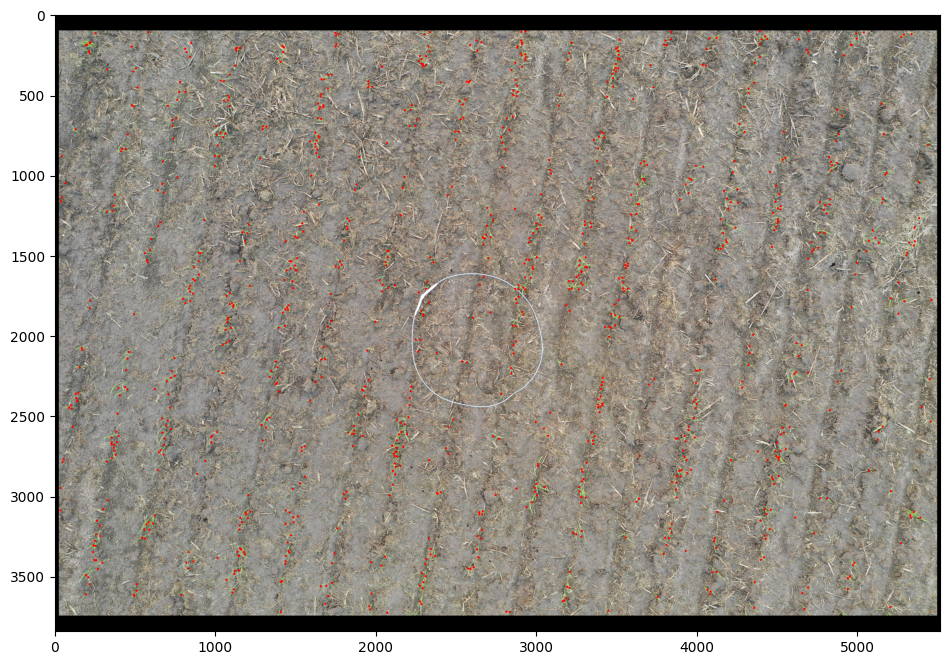

In [ ]:
draw_points(im_fill, df_labels_off)

## Mosaicos + BoundingBoxes

In [ ]:
# Grafica todos los bb para cada tile generado
# CUIDADO: alto tiempo de ejecución, posible memory overflow error

1/0 # Generando error para evitar interrupción indeseada

for row, column in product(range(ROWS), range(COLUMNS)):  # Genera todas las combinaciones (fias/columnas)
    print(column,row)
    index = get_index(row,column)
    
    # Se deben enviar copias del array y dataframe por ser objetos mutables
    draw_bb(np.copy(bb_tiles[index]['tile']),
            bb_tiles[index]['labels'].copy(),
            bb_tiles[index]['dims'])

ZeroDivisionError: division by zero

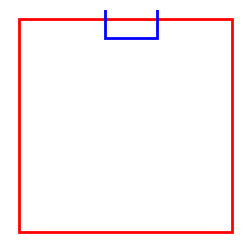

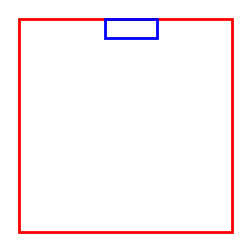

In [ ]:
tile = "0 720 240 960 "
label = "97 682 156 742"
label1 = "97 720 156 742 "
test_label(tile,label)
test_label(tile,label1)